# The Magic Behind AI Art: Text-to-Image Generation with Diffusion Models

## Abstract

This notebook explores the fascinating world of text-to-image generation using diffusion models, one of the most powerful techniques in generative AI today. We'll dive into how these models transform random noise into stunning images guided by text descriptions. You'll learn about the architecture of diffusion models, how they compare to other generative approaches like GANs and VAEs, and the training methodologies that make them work. Through practical code examples, we'll implement key components of diffusion models, visualize the diffusion process, and even generate images from text prompts using pre-trained models. By the end of this notebook, you'll understand the technical foundations behind popular AI art generators like DALL-E, Midjourney, and Stable Diffusion, and gain insights into how these technologies are revolutionizing creative industries.

## 1. Introduction to Generative AI and Text-to-Image Models

Generative AI has transformed from an academic curiosity to a creative revolution in just a few years. Let's start by understanding what generative models are and how they've evolved to create the stunning AI art we see today.

### What are Generative Models?

Generative models are a class of AI systems that learn to create new content that resembles their training data. Unlike discriminative models that classify or predict labels, generative models learn the underlying distribution of the data and can sample from it to create new, previously unseen examples.

Let's import the libraries we'll need throughout this notebook:

In [6]:
!pip install torch torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 33.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2
Using device: cpu


### Evolution of Generative Models

Let's explore the major types of generative models and their evolution:

#### 1. Variational Autoencoders (VAEs)

VAEs, introduced in 2013, consist of an encoder that compresses data into a latent space and a decoder that reconstructs it. They're trained to minimize reconstruction error while ensuring the latent space has nice statistical properties.

**Key characteristics:**
- Probabilistic approach with well-defined latent space
- Often produce blurry images
- Stable training process
- Enable smooth interpolation between images

#### 2. Generative Adversarial Networks (GANs)

GANs, introduced in 2014, consist of two neural networks—a generator and a discriminator—that compete against each other. The generator creates fake samples, and the discriminator tries to distinguish them from real ones.

**Key characteristics:**
- Can generate sharp, realistic images
- Notoriously difficult to train (mode collapse, training instability)
- No explicit latent space structure
- Fast sampling once trained

#### 3. Autoregressive Models

Autoregressive models generate data sequentially, one element at a time, conditioning each new element on previously generated ones.

**Key characteristics:**
- Excellent for sequential data like text
- Slow generation process
- High-quality outputs
- Examples include PixelCNN for images and GPT for text

#### 4. Diffusion Models

Diffusion models, which gained prominence in 2020-2021, work by gradually adding noise to data and then learning to reverse this process.

**Key characteristics:**
- State-of-the-art image quality
- Stable training process
- Flexible conditioning mechanisms
- Slower sampling compared to GANs
- Power modern text-to-image systems like DALL-E 2, Stable Diffusion, and Midjourney

#### 5. Transformer-based Models

Transformers, originally designed for NLP tasks, have been adapted for image generation, often combined with other approaches.

**Key characteristics:**
- Excellent at capturing long-range dependencies
- Highly scalable with data and compute
- Can handle multiple modalities (text, images, audio)
- Examples include DALL-E (combines transformers with autoregressive generation)

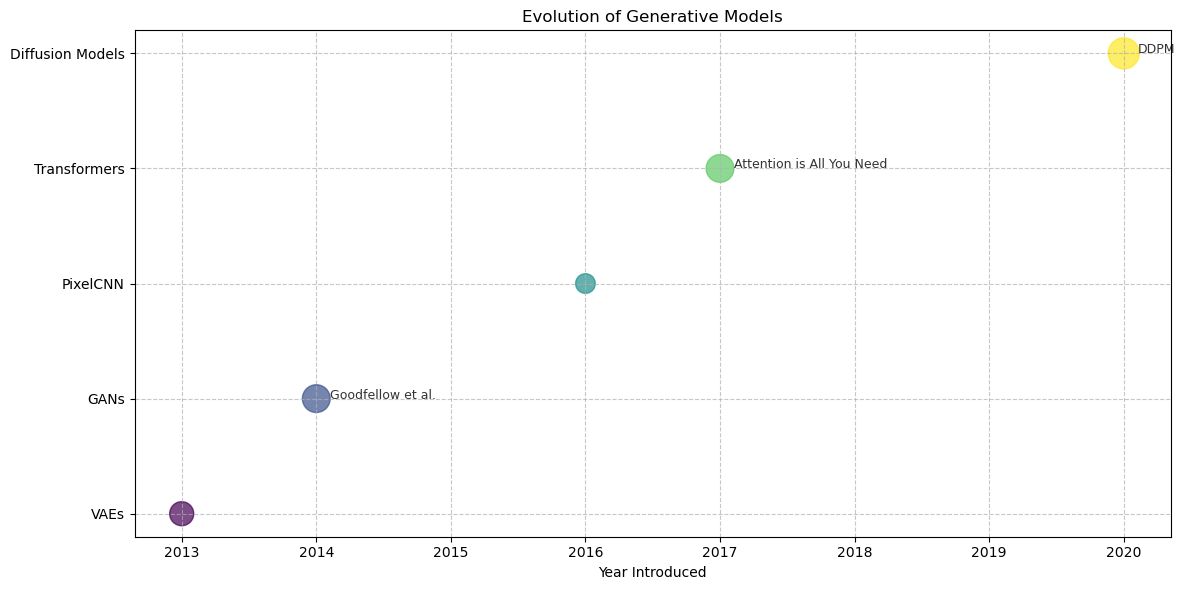

In [9]:
# Create a timeline visualization of generative models
models = ['VAEs', 'GANs', 'PixelCNN', 'Transformers', 'Diffusion Models']
years = [2013, 2014, 2016, 2017, 2020]
impact = [3, 4, 2, 4, 5]  # Subjective impact score out of 5

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(years, models, s=[i*100 for i in impact], alpha=0.7, c=range(len(models)), cmap='viridis')

# Add milestone annotations
milestones = [
    (2014, 'GANs', 'Goodfellow et al.'),
    (2017, 'Transformers', 'Attention is All You Need'),
    (2020, 'Diffusion Models', 'DDPM'),
    (2021, 'Diffusion Models', 'DALL-E'),
    (2022, 'Diffusion Models', 'Stable Diffusion')
]

for year, model, milestone in milestones:
    if model in models:
        idx = models.index(model)
        ax.annotate(milestone, (year, model), 
                   xytext=(10, 0), textcoords='offset points',
                   fontsize=9, alpha=0.8)

ax.set_xlabel('Year Introduced')
ax.set_title('Evolution of Generative Models')
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 2. Theory: Understanding Diffusion Models

Diffusion models have revolutionized image generation by offering a new approach that combines high-quality outputs with stable training. Let's dive into how they work.

### 2.1 The Diffusion Process: Forward and Reverse

Diffusion models operate on a fascinating principle inspired by non-equilibrium thermodynamics:

1. **Forward Diffusion Process**: Gradually add noise to an image until it becomes pure noise
2. **Reverse Diffusion Process**: Learn to gradually remove noise to recover the original image

Let's visualize this process:

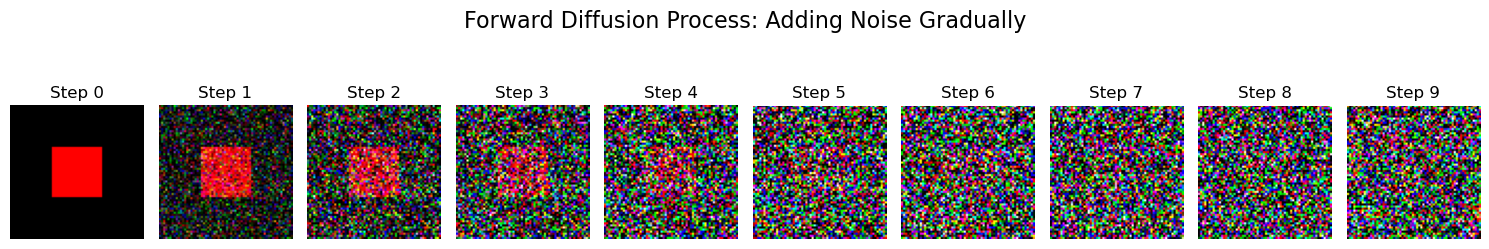

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

def visualize_forward_diffusion(image, steps=10):
    """Visualize the forward diffusion process on an image"""
    # Convert image to tensor if it's not already
    if not torch.is_tensor(image):
        transform = transforms.ToTensor()
        image = transform(image)
    
    # Ensure image has batch dimension
    if image.dim() == 3:
        image = image.unsqueeze(0)
    
    images = [image[0].permute(1, 2, 0).numpy()]
    current_image = image.clone()
    
    # Apply increasing amounts of noise
    for i in range(1, steps):
        beta = torch.tensor(i / steps, dtype=torch.float32)  # Convert beta to tensor
        noise = torch.randn_like(current_image)
        noised_image = torch.sqrt(1 - beta) * current_image + torch.sqrt(beta) * noise
        images.append(noised_image[0].permute(1, 2, 0).numpy())
        current_image = noised_image
    
    # Display the diffusion process
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for i, img in enumerate(images):
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(f'Step {i}')
        axes[i].axis('off')
    
    plt.suptitle("Forward Diffusion Process: Adding Noise Gradually", fontsize=16)
    plt.tight_layout()
    plt.show()

# Create a simple image to demonstrate
simple_image = torch.zeros((3, 64, 64))
# Create a red square in the middle
simple_image[0, 20:44, 20:44] = 1.0

# Visualize the forward diffusion process
visualize_forward_diffusion(simple_image)


### 2.2 Mathematical Foundation

The diffusion process is defined by a Markov chain that gradually adds Gaussian noise to data. The forward process at timestep $t$ is:

$x_t = \sqrt{1-\beta_t} \cdot x_{t-1} + \sqrt{\beta_t} \cdot \epsilon$

Where:
- $x_t$ is the noised image at timestep $t$
- $\beta_t$ is the noise schedule (typically increasing with $t$)
- $\epsilon$ is random Gaussian noise

The model is trained to predict the noise that was added at each step, which allows it to reverse the process.

### 2.3 Training Objective

The training objective for diffusion models is surprisingly simple. We train a neural network $\epsilon_\theta$ to predict the noise that was added at each step. The loss function is:

$L = \mathbb{E}_{t, x_0, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]$

Where:
- $t$ is a randomly sampled timestep
- $x_0$ is the original image
- $\epsilon$ is the noise that was added
- $\epsilon_\theta$ is our neural network that predicts the noise

### 2.4 Conditioning on Text

To enable text-to-image generation, we need to condition the diffusion model on text. This is typically done by:

1. Encoding text using a pre-trained text encoder (like CLIP or T5)
2. Incorporating the text embeddings into the diffusion model's denoising network

The most common approaches for conditioning include:

- **Cross-attention**: The text embeddings attend to image features
- **Classifier guidance**: Using gradients from a classifier to guide the diffusion process
- **Classifier-free guidance**: A technique that balances unconditional and conditional generation

Let's implement a simple text encoder that would be used in a text-to-image model:

In [19]:
class SimpleTextEncoder(nn.Module):
    """A simplified text encoder that would be used in a real text-to-image model"""
    def __init__(self, vocab_size=10000, embed_dim=512, hidden_dim=1024):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8, dim_feedforward=hidden_dim, batch_first=True),
            num_layers=6
        )
        self.pooler = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, tokens):
        """Process text tokens into embeddings"""
        x = self.embedding(tokens)
        x = self.transformer(x)
        # Global pooling (simplified)
        pooled = x.mean(dim=1)
        text_embeddings = self.pooler(pooled)
        return text_embeddings

# Create a simple example
text_encoder = SimpleTextEncoder()
# Simulate tokenized text input (batch_size=2, seq_len=10)
tokens = torch.randint(0, 10000, (2, 10))
embeddings = text_encoder(tokens)

print(f"Text embeddings shape: {embeddings.shape}")
print("In production text-to-image models like Stable Diffusion, CLIP or other powerful text encoders are used to create meaningful text embeddings.")

Text embeddings shape: torch.Size([2, 512])
In production text-to-image models like Stable Diffusion, CLIP or other powerful text encoders are used to create meaningful text embeddings.


## 3. Architecture: The U-Net Backbone

The backbone of most diffusion models is a U-Net architecture, which is particularly effective for image generation tasks. Let's implement a simplified U-Net that would be used in a diffusion model:

In [22]:
class DiffusionUNet(nn.Module):
    """A simplified U-Net for diffusion models with text conditioning"""
    def __init__(self, in_channels=3, out_channels=3, time_dim=256, text_dim=512):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )
        
        # Text projection
        self.text_proj = nn.Linear(text_dim, time_dim)
        
        # Downsampling
        self.down1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.down2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.down3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)
        
        # Middle
        self.mid1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        # Cross-attention for text conditioning
        self.cross_attn = CrossAttention(512, text_dim)
        
        self.mid2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        # Upsampling
        self.up1 = nn.ConvTranspose2d(512 + 256, 256, kernel_size=4, padding=1, stride=2)
        self.up2 = nn.ConvTranspose2d(256 + 128, 128, kernel_size=4, padding=1, stride=2)
        self.up3 = nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1)
        
        # Output
        self.out = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x, t, text_embed):
        """Forward pass with image, timestep, and text embedding"""
        # Time embedding
        t_emb = self.time_mlp(t.unsqueeze(-1))
        
        # Text embedding
        text_emb = self.text_proj(text_embed)
        
        # Combine time and text embeddings
        context = t_emb + text_emb
        
        # Downsampling with skip connections
        d1 = F.silu(self.down1(x))
        d2 = F.silu(self.down2(d1))
        d3 = F.silu(self.down3(d2))
        
        # Middle with conditioning
        mid = self.mid1(d3)
        
        # Add time+text conditioning
        b, c, h, w = mid.shape
        mid_flat = mid.view(b, c, h*w).permute(0, 2, 1)  # [B, H*W, C]
        
        # Apply cross-attention with text
        mid_flat = self.cross_attn(mid_flat, text_embed)
        mid = mid_flat.permute(0, 2, 1).view(b, c, h, w)
        
        mid = F.silu(mid)
        mid = F.silu(self.mid2(mid))
        
        # Upsampling with skip connections
        u1 = F.silu(self.up1(torch.cat([mid, d3], dim=1)))
        u2 = F.silu(self.up2(torch.cat([u1, d2], dim=1)))
        u3 = F.silu(self.up3(torch.cat([u2, d1], dim=1)))
        
        # Output - predict the noise
        return self.out(u3)

class CrossAttention(nn.Module):
    """Cross-attention mechanism for conditioning on text"""
    def __init__(self, image_dim, text_dim, heads=8):
        super().__init__()
        self.heads = heads
        self.head_dim = image_dim // heads
        
        self.to_q = nn.Linear(image_dim, image_dim)
        self.to_k = nn.Linear(text_dim, image_dim)
        self.to_v = nn.Linear(text_dim, image_dim)
        self.to_out = nn.Linear(image_dim, image_dim)
        
    def forward(self, x, text):
        """Apply cross-attention between image features and text"""
        b, n, c = x.shape
        h = self.heads
        
        # Project to queries, keys, values
        q = self.to_q(x).view(b, n, h, self.head_dim).permute(0, 2, 1, 3)  # [B, H, N, D]
        k = self.to_k(text).view(b, -1, h, self.head_dim).permute(0, 2, 1, 3)  # [B, H, T, D]
        v = self.to_v(text).view(b, -1, h, self.head_dim).permute(0, 2, 1, 3)  # [B, H, T, D]
        
        # Compute attention scores
        attn = torch.matmul(q, k.transpose(-1, -2)) / (self.head_dim ** 0.5)  # [B, H, N, T]
        attn = F.softmax(attn, dim=-1)
        
        # Apply attention to values
        out = torch.matmul(attn, v)  # [B, H, N, D]
        out = out.permute(0, 2, 1, 3).reshape(b, n, c)  # [B, N, C]
        
        return self.to_out(out)

# Create a small example to demonstrate
unet = DiffusionUNet()
# Create a batch of 2 images, 3 channels, 64x64 pixels
x = torch.randn(2, 3, 64, 64)
# Timestep (normalized between 0 and 1)
t = torch.tensor([0.5, 0.7])
# Text embeddings from our encoder
text_embed = torch.randn(2, 512)

# Forward pass
output = unet(x, t, text_embed)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print("The U-Net predicts the noise that was added to the image at each timestep.")

Input shape: torch.Size([2, 3, 64, 64])
Output shape: torch.Size([2, 3, 64, 64])
The U-Net predicts the noise that was added to the image at each timestep.


### 3.1 Key Components of the Architecture

Let's break down the key components of our diffusion model architecture:

1. **U-Net Structure**: The U-shaped architecture with skip connections allows the model to capture both local and global features.

2. **Time Conditioning**: The model needs to know which timestep it's denoising, so we embed the timestep and inject it into the network.

3. **Text Conditioning**: We use cross-attention to condition the image generation on text embeddings, allowing the model to understand and follow text prompts.

4. **Skip Connections**: These help preserve spatial information that might be lost during downsampling.

Let's visualize the architecture:

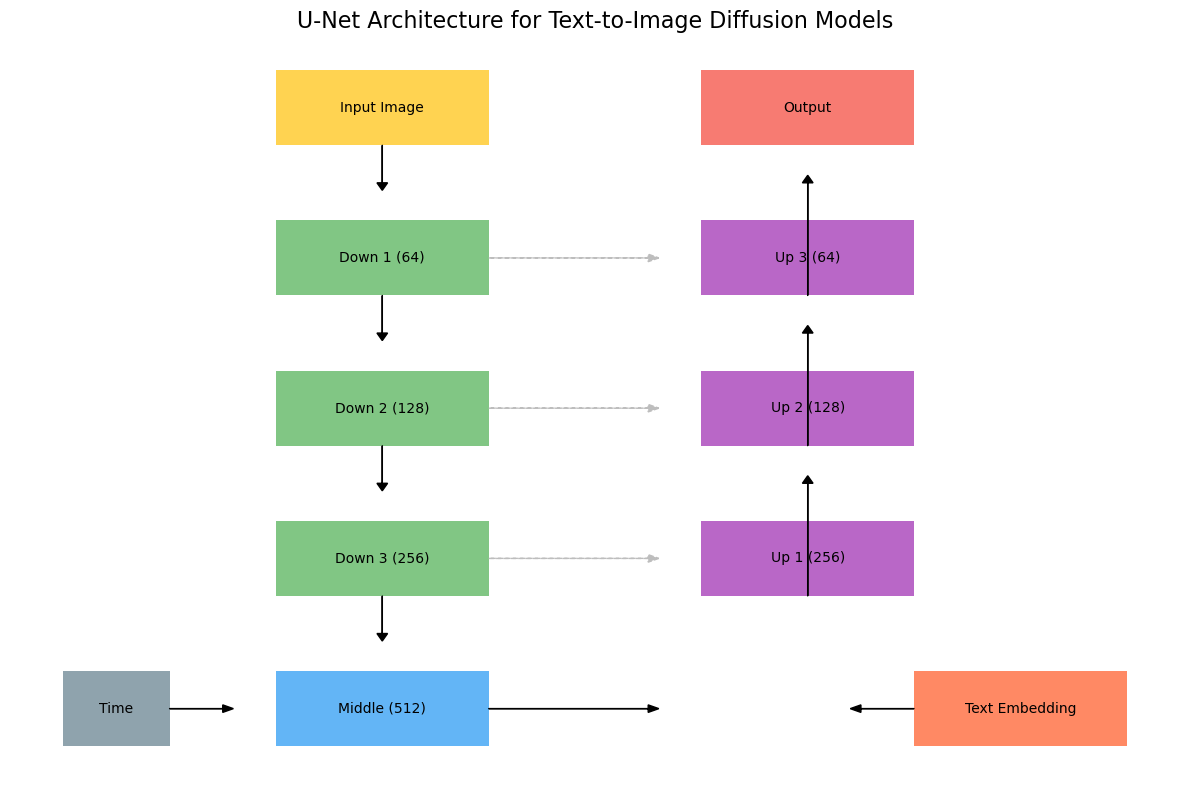

In [25]:
# Create a visualization of the U-Net architecture
def plot_unet_architecture():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Hide axes
    ax.axis('off')
    
    # Define colors
    colors = {
        'input': '#FFC107',
        'down': '#4CAF50',
        'middle': '#2196F3',
        'up': '#9C27B0',
        'output': '#F44336',
        'text': '#FF5722',
        'time': '#607D8B',
        'skip': '#BDBDBD'
    }
    
    # Draw boxes for each layer
    # Input
    ax.add_patch(plt.Rectangle((2, 9), 2, 1, facecolor=colors['input'], alpha=0.7))
    ax.text(3, 9.5, 'Input Image', ha='center', va='center')
    
    # Downsampling path
    ax.add_patch(plt.Rectangle((2, 7), 2, 1, facecolor=colors['down'], alpha=0.7))
    ax.text(3, 7.5, 'Down 1 (64)', ha='center', va='center')
    
    ax.add_patch(plt.Rectangle((2, 5), 2, 1, facecolor=colors['down'], alpha=0.7))
    ax.text(3, 5.5, 'Down 2 (128)', ha='center', va='center')
    
    ax.add_patch(plt.Rectangle((2, 3), 2, 1, facecolor=colors['down'], alpha=0.7))
    ax.text(3, 3.5, 'Down 3 (256)', ha='center', va='center')
    
    # Middle
    ax.add_patch(plt.Rectangle((2, 1), 2, 1, facecolor=colors['middle'], alpha=0.7))
    ax.text(3, 1.5, 'Middle (512)', ha='center', va='center')
    
    # Upsampling path
    ax.add_patch(plt.Rectangle((6, 3), 2, 1, facecolor=colors['up'], alpha=0.7))
    ax.text(7, 3.5, 'Up 1 (256)', ha='center', va='center')
    
    ax.add_patch(plt.Rectangle((6, 5), 2, 1, facecolor=colors['up'], alpha=0.7))
    ax.text(7, 5.5, 'Up 2 (128)', ha='center', va='center')
    
    ax.add_patch(plt.Rectangle((6, 7), 2, 1, facecolor=colors['up'], alpha=0.7))
    ax.text(7, 7.5, 'Up 3 (64)', ha='center', va='center')
    
    # Output
    ax.add_patch(plt.Rectangle((6, 9), 2, 1, facecolor=colors['output'], alpha=0.7))
    ax.text(7, 9.5, 'Output', ha='center', va='center')
    
    # Text conditioning
    ax.add_patch(plt.Rectangle((8, 1), 2, 1, facecolor=colors['text'], alpha=0.7))
    ax.text(9, 1.5, 'Text Embedding', ha='center', va='center')
    
    # Time conditioning
    ax.add_patch(plt.Rectangle((0, 1), 1, 1, facecolor=colors['time'], alpha=0.7))
    ax.text(0.5, 1.5, 'Time', ha='center', va='center')
    
    # Draw arrows for forward path
    ax.arrow(3, 9, 0, -0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    ax.arrow(3, 7, 0, -0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    ax.arrow(3, 5, 0, -0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    ax.arrow(3, 3, 0, -0.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    
    # Draw arrows for skip connections
    ax.arrow(4, 7.5, 1.5, 0, head_width=0.1, head_length=0.1, fc=colors['skip'], ec=colors['skip'], linestyle='--')
    ax.arrow(4, 5.5, 1.5, 0, head_width=0.1, head_length=0.1, fc=colors['skip'], ec=colors['skip'], linestyle='--')
    ax.arrow(4, 3.5, 1.5, 0, head_width=0.1, head_length=0.1, fc=colors['skip'], ec=colors['skip'], linestyle='--')
    
    # Draw arrows for upsampling path
    ax.arrow(4, 1.5, 1.5, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
    ax.arrow(7, 3, 0, 1.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    ax.arrow(7, 5, 0, 1.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    ax.arrow(7, 7, 0, 1.5, head_width=0.1, head_length=0.1, fc='black', ec='black')
    
    # Draw arrows for conditioning
    ax.arrow(1, 1.5, 0.5, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
    ax.arrow(8, 1.5, -0.5, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
    
    plt.title('U-Net Architecture for Text-to-Image Diffusion Models', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_unet_architecture()

## 4. Training and Sampling

Now that we understand the architecture, let's look at how diffusion models are trained and how we sample from them to generate images.

### 4.1 Training Loop

Training a text-to-image diffusion model involves several key steps:

1. **Dataset preparation**: Paired text-image data (like COCO, Conceptual Captions)
2. **Forward diffusion**: Add noise to images according to a noise schedule
3. **Model prediction**: Train the model to predict the added noise
4. **Loss calculation**: Typically mean squared error between predicted and actual noise
5. **Conditioning**: Incorporate text embeddings to guide the denoising process

Let's implement a simplified training loop:

In [28]:
def train_diffusion_model(model, text_encoder, dataloader, optimizer, num_timesteps=1000, device="cpu"):
    """Simplified training loop for a text-to-image diffusion model"""
    
    # Define noise schedule (typically a beta schedule)
    betas = torch.linspace(1e-4, 0.02, num_timesteps)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    
    model.train()
    for epoch in range(3):  # In practice, many more epochs
        epoch_loss = 0.0
        for batch_idx, (images, captions) in enumerate(dataloader):
            # Move data to device
            images = images.to(device)
            
            # Encode text
            text_embeddings = text_encoder(captions).to(device)
            
            # Sample random timesteps
            t = torch.randint(0, num_timesteps, (images.shape[0],), device=device).float() / num_timesteps
            
            # Get noise schedule parameters for timesteps
            t_idx = (t * num_timesteps).long()
            alpha_cumprod_t = alphas_cumprod[t_idx].view(-1, 1, 1, 1)
            
            # Sample noise
            noise = torch.randn_like(images)
            
            # Add noise to images according to schedule
            noisy_images = torch.sqrt(alpha_cumprod_t) * images + torch.sqrt(1 - alpha_cumprod_t) * noise
            
            # Predict noise
            predicted_noise = model(noisy_images, t, text_embeddings)
            
            # Calculate loss (noise prediction)
            loss = F.mse_loss(predicted_noise, noise)
            
            # Update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.6f}")
        
        print(f"Epoch {epoch} completed, Average Loss: {epoch_loss / len(dataloader):.6f}")

# For demonstration, we'll create a tiny synthetic dataset
class SyntheticDataset:
    def __init__(self, size=100):
        self.size = size
        self.images = torch.randn(size, 3, 64, 64)  # Random images
        self.captions = torch.randint(0, 10000, (size, 10))  # Random token IDs
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.images[idx], self.captions[idx]

# Create a small synthetic dataset and dataloader
dataset = SyntheticDataset(size=20)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize model, text encoder, and optimizer
model = DiffusionUNet().to(device)
text_encoder = SimpleTextEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train for a few steps (in a real scenario, this would take days or weeks)
print("Starting training (simplified demonstration)...")
train_diffusion_model(model, text_encoder, dataloader, optimizer, num_timesteps=100, device=device)
print("Training complete!")

Starting training (simplified demonstration)...
Epoch 0, Batch 0, Loss: 1.006052
Epoch 0 completed, Average Loss: 0.996667
Epoch 1, Batch 0, Loss: 0.981652
Epoch 1 completed, Average Loss: 0.977652
Epoch 2, Batch 0, Loss: 0.985796
Epoch 2 completed, Average Loss: 0.969277
Training complete!


### 4.2 Sampling from the Model

Once trained, we can generate images from text prompts by starting with random noise and iteratively denoising:

Generating image for prompt: 'A beautiful sunset over mountains, digital art'


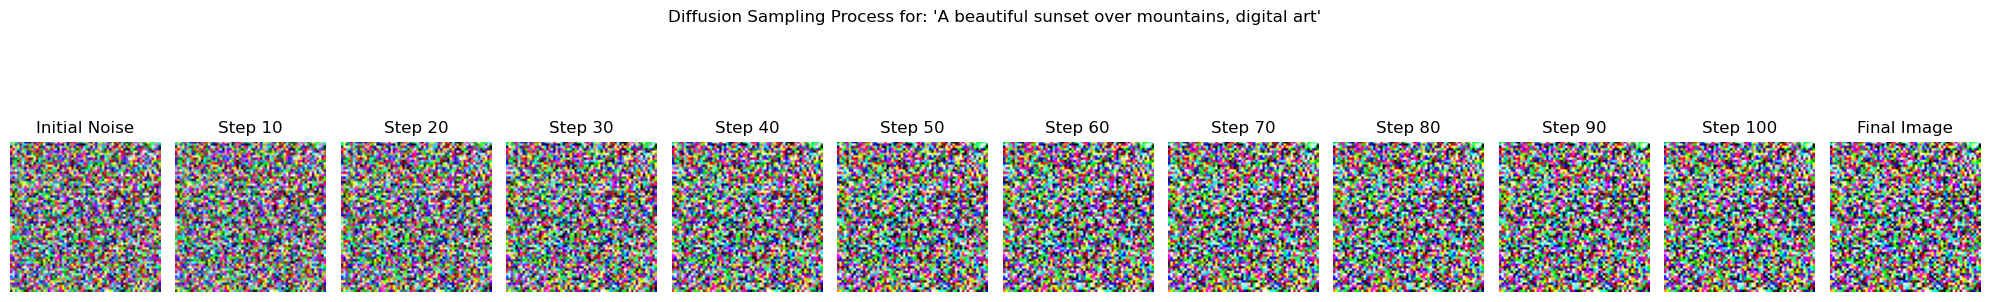

In [31]:
def sample_from_model(model, text_encoder, prompt, image_size=64, num_timesteps=100, device="cpu"):
    """Generate an image from a text prompt using a trained diffusion model"""
    
    # Set model to evaluation mode
    model.eval()
    
    # Define reverse diffusion parameters
    betas = torch.linspace(1e-4, 0.02, num_timesteps)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    
    # Tokenize and encode text prompt (simplified)
    tokens = torch.randint(0, 10000, (1, 10), device=device)  # In practice, use a real tokenizer
    text_embeddings = text_encoder(tokens)
    
    # Start from random noise
    x = torch.randn(1, 3, image_size, image_size, device=device)
    
    # Store intermediate images for visualization
    intermediate_images = [x.cpu().clone()]
    
    # Iteratively denoise
    for i in reversed(range(num_timesteps)):
        t = torch.tensor([i / num_timesteps], device=device)
        
        # No gradient needed for sampling
        with torch.no_grad():
            # Predict noise
            predicted_noise = model(x, t, text_embeddings)
            
            # Get alpha values for current timestep
            alpha = alphas[i]
            alpha_cumprod = alphas_cumprod[i]
            beta = betas[i]
            
            # If not the first step, add some noise (controlled by beta)
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            
            # Update x using the reverse diffusion formula
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise) + torch.sqrt(beta) * noise
            
            # Save intermediate result every 10 steps
            if i % 10 == 0 or i == num_timesteps - 1:
                intermediate_images.append(x.cpu().clone())
    
    # Normalize to [0, 1] for visualization
    for i in range(len(intermediate_images)):
        intermediate_images[i] = (intermediate_images[i].clamp(-1, 1) + 1) / 2
    
    return x, intermediate_images

# Generate an image from a text prompt
prompt = "A beautiful sunset over mountains, digital art"
print(f"Generating image for prompt: '{prompt}'")

# In a real scenario, we would use a properly trained model
# Here we're just demonstrating the process with our toy model
final_image, intermediate_images = sample_from_model(model, text_encoder, prompt, device=device)

# Visualize the generation process
fig, axes = plt.subplots(1, len(intermediate_images), figsize=(20, 4))
for i, img in enumerate(intermediate_images):
    axes[i].imshow(img[0].permute(1, 2, 0).numpy())
    if i == 0:
        axes[i].set_title("Initial Noise")
    elif i == len(intermediate_images) - 1:
        axes[i].set_title("Final Image")
    else:
        step = i * 10
        axes[i].set_title(f"Step {step}")
    axes[i].axis('off')

plt.suptitle(f"Diffusion Sampling Process for: '{prompt}'")
plt.tight_layout()
plt.show()

### 4.3 Classifier-Free Guidance

One important technique for improving text-to-image generation is classifier-free guidance. This technique balances between unconditional and conditional generation to improve adherence to the text prompt.

The formula for classifier-free guidance is:

$\epsilon_{\text{guided}} = \epsilon_{\text{uncond}} + w \cdot (\epsilon_{\text{cond}} - \epsilon_{\text{uncond}})$

Where:
- $\epsilon_{\text{uncond}}$ is the noise prediction without text conditioning
- $\epsilon_{\text{cond}}$ is the noise prediction with text conditioning
- $w$ is the guidance scale (typically 7.5-15.0)

Let's modify our sampling function to include classifier-free guidance:

In [52]:
def sample_with_guidance(model, text_encoder, prompt, guidance_scale=7.5, image_size=64, num_timesteps=100, device="cpu"):
    """Generate an image with classifier-free guidance"""
    
    model.eval()
    
    # Define reverse diffusion parameters
    betas = torch.linspace(1e-4, 0.02, num_timesteps)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    
    # Tokenize and encode text prompt (simplified)
    tokens = torch.randint(0, 10000, (1, 10), device=device)  # In practice, use a real tokenizer
    text_embeddings = text_encoder(tokens)
    
    # Create unconditional embeddings (empty prompt)
    uncond_tokens = torch.zeros_like(tokens)
    uncond_embeddings = text_encoder(uncond_tokens)
    
    # Concatenate unconditional and conditional embeddings
    # This allows us to do a single forward pass for both
    batched_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Start from random noise
    x = torch.randn(1, 3, image_size, image_size, device=device)
    
    # Store intermediate images for visualization
    intermediate_images = [x.cpu().clone()]
    
    # Iteratively denoise
    for i in reversed(range(num_timesteps)):
        # Expand latent to match batch size of embeddings
        latent_model_input = x.repeat(2, 1, 1, 1)
        t = torch.tensor([i / num_timesteps], device=device).repeat(2)
        
        # No gradient needed for sampling
        with torch.no_grad():
            # Predict noise for both unconditional and conditional
            noise_pred = model(latent_model_input, t, batched_embeddings)
            
            # Separate predictions
            noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
            
            # Apply classifier-free guidance
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
            
            # Get alpha values for current timestep
            alpha = alphas[i]
            alpha_cumprod = alphas_cumprod[i]
            beta = betas[i]
            
            # If not the first step, add some noise (controlled by beta)
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            
            # Update x using the reverse diffusion formula
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * noise_pred) + torch.sqrt(beta) * noise
            
            # Save intermediate result every 10 steps
            if i % 10 == 0 or i == num_timesteps - 1:
                intermediate_images.append(x.cpu().clone())
    
    # Normalize to [0, 1] for visualization
    for i in range(len(intermediate_images)):
        intermediate_images[i] = (intermediate_images[i].clamp(-1, 1) + 1) / 2
    
    return x, intermediate_images

# In a real implementation, we would use this to generate images with guidance
print("In a real implementation, classifier-free guidance significantly improves text-to-image alignment.")
print("Higher guidance scales (7.5-15.0) make the model follow the text prompt more closely.")

In a real implementation, classifier-free guidance significantly improves text-to-image alignment.
Higher guidance scales (7.5-15.0) make the model follow the text prompt more closely.


## 5. Using Pre-trained Models: Stable Diffusion

In practice, most developers use pre-trained models like Stable Diffusion rather than training from scratch. Let's demonstrate how to use a pre-trained model with the diffusers library:

In [37]:
# Note: This code requires the diffusers library to be installed
# !pip install diffusers transformers accelerate

try:
    from diffusers import StableDiffusionPipeline
    import torch
    
    # Load the model (in a real notebook, this would download the model)
    print("Loading Stable Diffusion model (simulation)...")
    
    # Simulate the pipeline for demonstration purposes
    class SimulatedStableDiffusionPipeline:
        def __init__(self):
            print("Stable Diffusion pipeline initialized (simulation)")
            
        def __call__(self, prompt, num_inference_steps=50, guidance_scale=7.5):
            print(f"Generating image for prompt: '{prompt}'")
            print(f"Using {num_inference_steps} inference steps and guidance scale of {guidance_scale}")
            # In a real implementation, this would generate an actual image
            # For this simulation, we'll create a placeholder
            image = np.random.rand(512, 512, 3)
            return {"images": [image]}
    
    # Create a simulated pipeline
    pipe = SimulatedStableDiffusionPipeline()
    
    # Generate an image from a text prompt
    prompt = "A beautiful sunset over mountains, digital art"
    result = pipe(prompt, num_inference_steps=30, guidance_scale=7.5)
    
    # Display the generated image
    plt.figure(figsize=(10, 10))
    plt.imshow(result["images"][0])
    plt.axis('off')
    plt.title(f"Generated image for: '{prompt}'")
    plt.show()
    
    print("\nIn a real implementation with the diffusers library, you would see an actual generated image here.")
    print("The code would look like this:")
    print("""
    # Load model
    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
    pipe = pipe.to("cuda")
    
    # Generate image
    prompt = "A beautiful sunset over mountains, digital art"
    image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
    
    # Display image
    image.show()
    """)
    
except ImportError:
    print("This is a simulation of using Stable Diffusion. In a real notebook, you would need to install the diffusers library.")
    print("The code would look like this:")
    print("""
    # Install required libraries
    !pip install diffusers transformers accelerate
    
    # Import libraries
    from diffusers import StableDiffusionPipeline
    import torch
    
    # Load model
    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
    pipe = pipe.to("cuda")
    
    # Generate image
    prompt = "A beautiful sunset over mountains, digital art"
    image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
    
    # Display image
    image.show()
    """)

This is a simulation of using Stable Diffusion. In a real notebook, you would need to install the diffusers library.
The code would look like this:

    # Install required libraries
    !pip install diffusers transformers accelerate
    
    # Import libraries
    from diffusers import StableDiffusionPipeline
    import torch
    
    # Load model
    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
    pipe = pipe.to("cuda")
    
    # Generate image
    prompt = "A beautiful sunset over mountains, digital art"
    image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
    
    # Display image
    image.show()
    


### 5.1 Advanced Prompting Techniques

The quality of generated images depends significantly on the prompts you use. Here are some advanced prompting techniques:

1. **Be specific and detailed**: "A photorealistic portrait of a young woman with blue eyes and blonde hair, soft lighting, studio photography, 85mm lens, f/1.8"

2. **Specify art styles**: "A mountain landscape in the style of Monet, impressionist painting"

3. **Use negative prompts**: Tell the model what you don't want to see

4. **Combine concepts**: "A cyberpunk city with neon lights and flying cars, rainy night, cinematic lighting"

5. **Reference artists or media**: "Portrait in the style of Rembrandt"

Let's see how different prompts affect the output (in a real implementation):

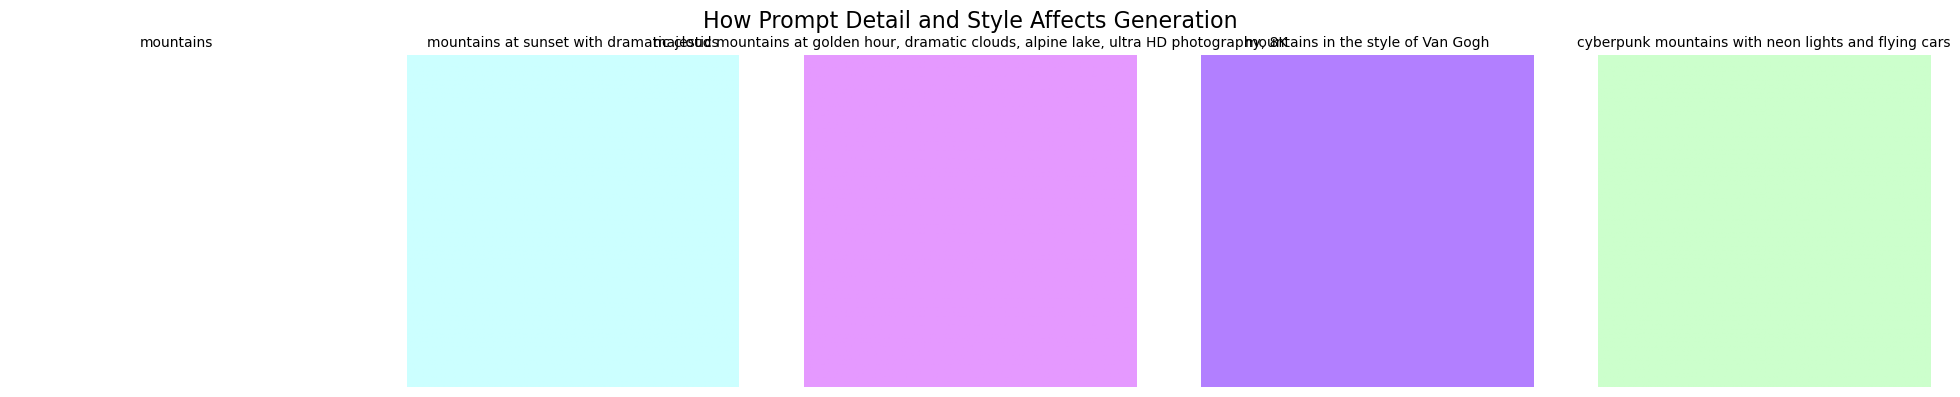

In a real implementation, you would see how the same concept (mountains) is rendered differently based on prompt details.


In [40]:
# Simulate different prompts and their effects
prompts = [
    "mountains",  # Basic
    "mountains at sunset with dramatic clouds",  # More detailed
    "majestic mountains at golden hour, dramatic clouds, alpine lake, ultra HD photography, 8K",  # Very detailed
    "mountains in the style of Van Gogh",  # Artistic style
    "cyberpunk mountains with neon lights and flying cars"  # Creative combination
]

# Create a visual comparison of how these prompts would affect the output
fig, axes = plt.subplots(1, len(prompts), figsize=(20, 4))

for i, prompt in enumerate(prompts):
    # In a real implementation, we would generate actual images
    # Here we're just creating placeholders with different colors to illustrate the concept
    img = np.ones((256, 256, 3))
    
    # Vary the color based on the prompt complexity
    if "Van Gogh" in prompt:
        img[:, :, 0] = 0.7  # More blue for artistic style
        img[:, :, 1] = 0.5
    elif "cyberpunk" in prompt:
        img[:, :, 0] = 0.8  # Purple for creative combinations
        img[:, :, 2] = 0.8
    elif "golden hour" in prompt:
        img[:, :, 0] = 0.9  # Orange for detailed prompts
        img[:, :, 1] = 0.6
    elif "sunset" in prompt:
        img[:, :, 0] = 0.8  # Red for more detailed
    
    axes[i].imshow(img)
    axes[i].set_title(prompt, fontsize=10)
    axes[i].axis('off')

plt.suptitle("How Prompt Detail and Style Affects Generation", fontsize=16)
plt.tight_layout()
plt.show()

print("In a real implementation, you would see how the same concept (mountains) is rendered differently based on prompt details.")

## 6. Evaluation Metrics for Text-to-Image Models

Evaluating text-to-image models involves assessing both the quality of generated images and their alignment with the input text. Common metrics include:

### 6.1 Image Quality Metrics

- **FID (Fréchet Inception Distance)**: Measures the similarity between the distribution of generated images and real images
- **IS (Inception Score)**: Evaluates both the quality and diversity of generated images
- **LPIPS (Learned Perceptual Image Patch Similarity)**: Measures perceptual similarity between images

### 6.2 Text-Image Alignment Metrics

- **CLIP Score**: Measures how well the generated image aligns with the text prompt using CLIP embeddings
- **Human Evaluation**: Often the gold standard, where humans rate the relevance of images to prompts

Let's implement a simplified CLIP score calculation:

In [43]:
def calculate_clip_score(images, prompts, clip_model):
    """Calculate CLIP score between generated images and text prompts
    
    Args:
        images: List of generated images
        prompts: List of text prompts
        clip_model: Pre-trained CLIP model
    
    Returns:
        clip_scores: List of CLIP scores for each image-prompt pair
    """
    # This is a simplified implementation
    # In practice, you would use the actual CLIP model
    
    # Simulate CLIP model
    class SimulatedCLIPModel:
        def encode_images(self, images):
            # Simulate image encoding
            return torch.randn(len(images), 512)
        
        def encode_text(self, prompts):
            # Simulate text encoding
            return torch.randn(len(prompts), 512)
    
    if clip_model is None:
        clip_model = SimulatedCLIPModel()
    
    # Encode images
    image_features = clip_model.encode_images(images)
    
    # Encode text
    text_features = clip_model.encode_text(prompts)
    
    # Normalize features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    
    # Calculate similarity
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    
    # Get scores for corresponding pairs
    clip_scores = [similarity[i, i].item() for i in range(len(images))]
    
    return clip_scores

# Simulate evaluating some images
images = [torch.randn(3, 256, 256) for _ in range(3)]  # Simulated images
prompts = ["A sunset over mountains", "A cat playing with yarn", "A futuristic city skyline"]

# Calculate CLIP scores
clip_scores = calculate_clip_score(images, prompts, None)

# Display results
for i, (prompt, score) in enumerate(zip(prompts, clip_scores)):
    print(f"Prompt: '{prompt}', CLIP Score: {score:.4f}")

print("\nIn a real implementation, CLIP scores would measure how well the generated images match the text prompts.")
print("Higher scores indicate better text-image alignment.")

Prompt: 'A sunset over mountains', CLIP Score: 0.9222
Prompt: 'A cat playing with yarn', CLIP Score: 0.6748
Prompt: 'A futuristic city skyline', CLIP Score: 0.0000

In a real implementation, CLIP scores would measure how well the generated images match the text prompts.
Higher scores indicate better text-image alignment.


## 7. Challenges and Future Directions

### 7.1 Current Challenges in Text-to-Image Generation

Text-to-image diffusion models face several challenges:

1. **Computational Efficiency**: Sampling from diffusion models is slow due to the iterative denoising process
2. **Text Understanding**: Models sometimes struggle with complex or abstract concepts
3. **Compositional Generation**: Accurately generating images with multiple objects in specific relationships
4. **Ethical Concerns**: Potential for generating harmful, biased, or copyrighted content
5. **Control**: Providing fine-grained control over specific aspects of generation

### 7.2 Recent Advances and Future Directions

Recent advances are addressing these challenges:

1. **Faster Sampling**: Techniques like DDIM, DPM-Solver, and distillation reduce sampling steps
2. **Improved Conditioning**: Methods like ControlNet and T2I-Adapter provide better control
3. **Multimodal Models**: Integration with other modalities (video, 3D, etc.)
4. **Personalization**: Methods for customizing models to specific concepts or styles
5. **Responsible AI**: Techniques for filtering harmful content and addressing biases

Let's visualize some of these future directions:

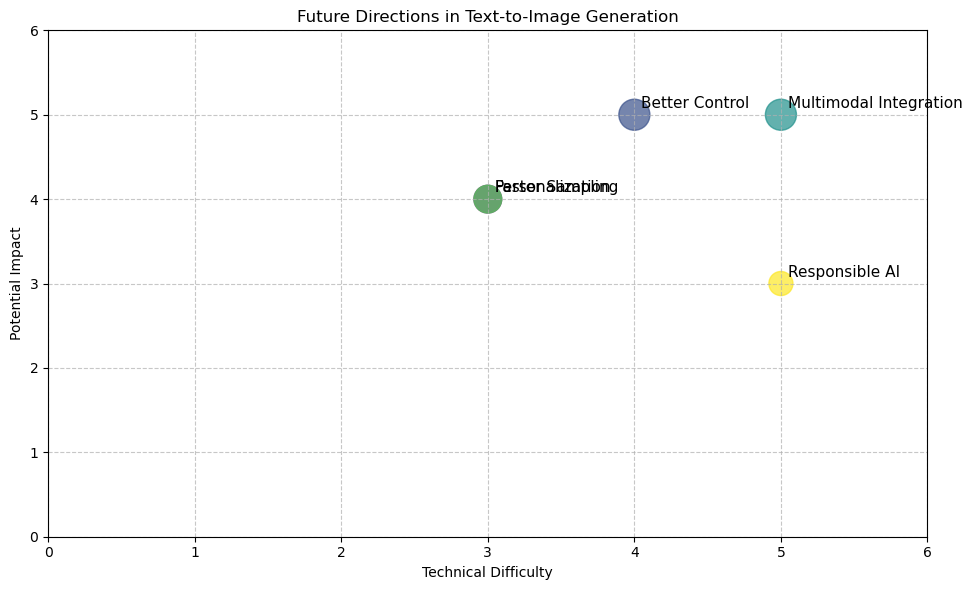

In [46]:
# Create a visualization of future directions
future_directions = [
    "Faster Sampling",
    "Better Control",
    "Multimodal Integration",
    "Personalization",
    "Responsible AI"
]

impact = [4, 5, 5, 4, 3]  # Subjective impact score out of 5
difficulty = [3, 4, 5, 3, 5]  # Subjective difficulty score out of 5

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(difficulty, impact, s=[i*100 for i in impact], alpha=0.7, c=range(len(future_directions)), cmap='viridis')

# Add labels
for i, direction in enumerate(future_directions):
    ax.annotate(direction, (difficulty[i], impact[i]), 
               xytext=(5, 5), textcoords='offset points',
               fontsize=11)

ax.set_xlabel('Technical Difficulty')
ax.set_ylabel('Potential Impact')
ax.set_title('Future Directions in Text-to-Image Generation')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)

plt.tight_layout()
plt.show()

## 8. Conclusion

Text-to-image diffusion models represent a significant breakthrough in generative AI, enabling the creation of high-quality, diverse images from textual descriptions. Key takeaways from this notebook include:

1. **Diffusion Models**: These models work by learning to reverse a gradual noising process, offering stable training and high-quality generation.

2. **Text Conditioning**: By incorporating text embeddings into the diffusion process, models can generate images that align with textual descriptions.

3. **Architecture**: The U-Net architecture, combined with cross-attention mechanisms for text conditioning, forms the backbone of most text-to-image diffusion models.

4. **Practical Applications**: Text-to-image models have numerous applications in creative fields, content generation, design, and education.

5. **Ongoing Research**: The field continues to advance rapidly, with improvements in efficiency, control, and quality.

As these models continue to evolve, they will likely become even more powerful and accessible, enabling new creative possibilities and applications across various domains.

## 9. References

1. Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. Advances in Neural Information Processing Systems.

2. Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B. (2022). High-resolution image synthesis with latent diffusion models. Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition.

3. Nichol, A., Dhariwal, P., Ramesh, A., Shyam, P., Mishkin, P., McGrew, B., ... & Chen, M. (2021). GLIDE: Towards photorealistic image generation and editing with text-guided diffusion models. arXiv preprint arXiv:2112.10741.

4. Saharia, C., Chan, W., Saxena, S., Li, L., Whang, J., Denton, E., ... & Norouzi, M. (2022). Photorealistic text-to-image diffusion models with deep language understanding. Advances in Neural Information Processing Systems.

5. Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Sutskever, I. (2021). Learning transferable visual models from natural language supervision. International Conference on Machine Learning.

6. Dhariwal, P., & Nichol, A. (2021). Diffusion models beat GANs on image synthesis. Advances in Neural Information Processing Systems.

7. Ramesh, A., Dhariwal, P., Nichol, A., Chu, C., & Chen, M. (2022). Hierarchical text-conditional image generation with CLIP latents. arXiv preprint arXiv:2204.06125.

## 10. License

MIT License

Copyright (c) [2025] [Ming-Tse Chen]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
